# A simple and flexible model for record matching

#### Libraries needed

In [2]:
# standard python data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# standard sklearn components
from sklearn.pipeline import make_union, make_pipeline # make_union to stack several transformers
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans as Cluster

# Suricate components
from suricate.lrdftransformers import VectorizerConnector, ExactConnector, FuzzyConnector, VisualHelper
from suricate.preutils import createmultiindex
from suricate.lrdftransformers.cluster import ClusterQuestions, ClusterClassifier
from suricate.pipeline import PruningLrSbsClf, PipeLrClf
from suricate.sbsdftransformers import FuncSbsComparator

#### Load the data

In [13]:
n_rows = 200
from suricate.data.companies import getXlr, getytrue
df_X = getXlr(nrows=n_rows)
left = df_X[0]
right = df_X[1]
y_true = getytrue()
y_true = y_true.loc[
    y_true.index.intersection(createmultiindex(X=df_X))
]
n_possible_pairs= left.shape[0]*right.shape[0]
print('Two datasets of size {} and {}  rows yield:\n {} possible pairs to scan --> manually exhausting'.format(left.shape[0], right.shape[0], n_possible_pairs))
left.sample(5)

Two datasets of size 200 and 200  rows yield:
 40000 possible pairs to scan --> manually exhausting


,name,street,city,postalcode,duns,countrycode
ix,,,,,,
066c325e-fd41-40f0-864b-a99af89f9fd5,intersport,6 am westpark,ingolstadt,85057,NaN,DE
e2dbddca-9b25-4796-9f73-96e9f6994c6a,kalzbw reglab 4 cottbus,66 sielower landstr,cottbus,3044,NaN,DE
536d4a08-8f02-4ec5-9b7d-e02fa09beb6a,ge aviation,arle court,cheltenham,gl51 0tp,505518316.0,GB
e8c68ece-5bfb-4a0d-bc02-b663d4945580,uk space agency,north star avenue,swindon,sn2 1sz,NaN,GB
1b69ccb6-5901-4746-b1f9-8eef0d9a9870,nespresso deutschland gmbh,speditionsstrae,dusseldorf,40221,NaN,DE


# How similar are the records with one another?

#### The framework is fully compatible with open-source Scikit-Learn Machine Learning libraries
- A VectorizerConnector is a Left-Right Comparator using a tokenizer and cosine similarity to compare two fields

In [14]:
scorer = make_union(*[
    VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2)),
     VectorizerConnector(on='name', analyzer='char', ngram_range=(1,2)),
    VectorizerConnector(on='street', analyzer='word', ngram_range=(1,2)),
    VectorizerConnector(on='city', analyzer='char', ngram_range=(1,2)),
    ExactConnector(on='duns'),
    ExactConnector(on='countrycode')
])
imp = SimpleImputer(strategy='constant', fill_value=0)

pca = PCA(n_components=2)
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
t2d = make_pipeline(*[scorer, imp, pca, scaler])

X_score2d = t2d.fit_transform(df_X)

#### Time needed to process the data

In [15]:
# %%timeit
# t2.fit_transform(df_X)

In [16]:
#print('{} pairs processed per second'.format(df_X[0].shape[0]*df_X[1].shape[0] / 8))

### Density plot: how similar are the matches on a 2-d space
Using a sample of maximum 500 lines out of all possible pairs as it is computation intensive

# Asking hard questions to train the model

### Cluster your data
Support all sklearn clusters

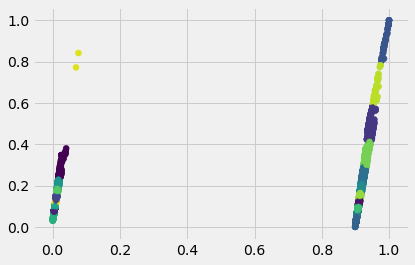

In [18]:
cluster = Cluster(n_clusters=20)
explorer = ClusterQuestions(transformer=t2d, cluster=cluster)
y_cluster = explorer.fit_predict(X=df_X)
plt.scatter(X_score2d[:, 0], X_score2d[:, 1], c=y_cluster);

### Ask representative questions

In [19]:
questions1 = explorer.representative_questions(n_questions=40)
questions1.sort_values(by='similarity').sample(5)

n_questions bigger than size of cluster for cluster 18


,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
ad6aa35d-b6ee-41b5-992e-cb6347071891,501ad89f-f5ce-487d-b5c6-ea6640f79e47,yoshida deutschland gmbh ykk,ge aviation systems ltd,33 ostring,cheltenham,mainhausen,cheltenham,63533,gl528sf,NaN,NaN,DE,GB,0,0.018847
f21fdcf5-a8b8-4582-8a04-6722c121b836,afe75b2f-6adc-4d92-975e-2f366d6809d7,smiths aerospace customer services,galileo avionica spa,bishops cleeve,2 via dei castelli romani,cheltenham,pomeziarome,gl528yb,00040,288525181.0,NaN,GB,IT,4,0.011281
ea4e028b-b041-4b62-9e50-d9ad49e80f87,bb3e4157-f4ea-4df4-950f-dc0f720e0592,franz spahn,temai ingenieros,7 wiedhof,10 calle de rivas,bad salzdetfurth,coslada,31162,28821,NaN,461592987.0,DE,ES,19,0.007055
76e834db-6e0c-400a-8f51-98b2652fd479,67556824-f4d9-422d-ad67-052bf578302d,datalis,international rectifier gmbh,8 avenue gutenberg,frankfurter str,portet sur garonne,neu isenburg,31125,63263,260332779.0,317777985.0,FR,DE,10,0.014561
7ca58742-beb2-485d-936d-cdeaf84a935b,40cdc6fb-dafe-4102-bdf3-693b8cbad832,united parcel service,sz druck verlagsservice gmbh,1 grlitzer strae,2 6 martin luther str,neuss,sankt augustin,41401,53757,315081096.0,NaN,DE,DE,9,0.919168


In [10]:
answer1 = y_true
cluster_composition = explorer.cluster_composition(y=answer1, normalize='index')
cluster_composition

y_true,0,1
cluster,,
1,1.000000,0.000000
2,0.923077,0.076923
3,1.000000,0.000000
5,0.000000,1.000000
6,1.000000,0.000000
7,1.000000,0.000000
11,1.000000,0.000000
12,1.000000,0.000000
13,1.000000,0.000000


### Asking more pointed questions on mixed clusters

In [20]:
questions2 = explorer.pointed_questions(y=answer1,n_questions=10)
questions2.sort_values(by='similarity')

name_left  \
ix_left                              ix_right                                                                         
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17                    ge measurement control   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894       smiths aerospace electronic systems   
                                     de6a8251-a6e9-44ab-ad06-55783bb54cbd       smiths aerospace electronic systems   
f89ddf6d-2770-44a7-9788-3bf2b89671c6 fbba638f-f4cd-4c27-93a4-a99d8e4ed841                   aeroflex test solutions   
afe75b2f-6adc-4d92-975e-2f366d6809d7 8fcd15a7-046d-4080-8c4e-ef7a327f3096                      galileo avionica spa   
95f31722-137b-4d41-91e8-53ff8cbb9c50 8fcd15a7-046d-4080-8c4e-ef7a327f3096                      galileo avionica spa   
a17ba961-73be-4421-b31f-bb176a09e058 4247e534-e143-4f1b-ac98-fa59f1c004c8                       honeywell aerospace   
c5f81518-76a2-4cf2-9d01-a59ff2ec86b3 cce26ebb-988f-4b00-9ef5-c3dc46eb34de                   ge aviation systems ltd   
6880aa5d-69dd-476f-8883-26d92867022d a90adf42-d16b-4367-851c-5091cd41cea7                   ge aviation systems ltd   
8c071814-2bec-4693-b5bc-524d149161f2 cce26ebb-988f-4b00-9ef5-c3dc46eb34de  ge aviation systems ltdcustomer services   

                                                                                           name_right  \
ix_left                              ix_right                                                           
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17               druck limited   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894                 ge aviation   
                                     de6a8251-a6e9-44ab-ad06-55783bb54cbd  moog uk cheltenham limited   
f89ddf6d-2770-44a7-9788-3bf2b89671c6 fbba638f-f4cd-4c27-93a4-a99d8e4ed841                aeroflex ltd   
afe75b2f-6adc-4d92-975e-2f366d6809d7 8fcd15a7-046d-4080-8c4e-ef7a327f3096                selex es spa   
95f31722-137b-4d41-91e8-53ff8cbb9c50 8fcd15a7-046d-4080-8c4e-ef7a327f3096                selex es spa   
a17ba961-73be-4421-b31f-bb176a09e058 4247e534-e143-4f1b-ac98-fa59f1c004c8   honeywell engines systems   
c5f81518-76a2-4cf2-9d01-a59ff2ec86b3 cce26ebb-988f-4b00-9ef5-c3dc46eb34de                 ge aviation   
6880aa5d-69dd-476f-8883-26d92867022d a90adf42-d16b-4367-851c-5091cd41cea7                 ge aviation   
8c071814-2bec-4693-b5bc-524d149161f2 cce26ebb-988f-4b00-9ef5-c3dc46eb34de                 ge aviation   

                                                                                         street_left  \
ix_left                              ix_right                                                          
816d262e-cf5d-405c-9012-df0053cfd848 aeba4b32-076d-4a65-bbdc-5a94c7bd5e17              fir tree lane   
7deb146f-57f9-4a7b-b05f-1784c677bdf1 42a5e929-3270-4700-b3c1-08ea755cb894                 cheltenham   
                                     de6a8251-a6e9-44ab-ad06-55783bb54cbd                 cheltenham   
f89ddf6d-2770-44a7-9788-3bf2b89671c6 fbba638f-f4cd-4c27-93a4-a99d8e4ed841               school close   
afe75b2f-6adc-4d92-975e-2f366d6809d7 8fcd15a7-046d-4080-8c4e-ef7a327f3096  2 via dei castelli romani   
95f31722-137b-4d41-91e8-53ff8cbb9c50 8fcd15a7-046d-4080-8c4e-ef7a327f3096  2 via dei castelli romani   
a17ba961-73be-4421-b31f-bb176a09e058 4247e534-e143-4f1b-ac98-fa59f1c004c8                   190th st   
c5f81518-76a2-4cf2-9d01-a59ff2ec86b3 cce26ebb-988f-4b00-9ef5-c3dc46eb34de             bishops cleeve   
6880aa5d-69dd-476f-8883-26d92867022d a90adf42-d16b-4367-851c-5091cd41cea7                 arle court   
8c071814-2bec-4693-b5bc-524d149161f2 cce26ebb-988f-4b00-9ef5-c3dc46eb34de               evesham road   

                                                                                          street_right  \
ix_left                              ix_right                

In [ ]:
answer2 = y_true
cluster_composition = explorer.cluster_composition(y=y_true, normalize='index').sort_values(by=1, ascending=False)
cluster_composition

### Scatter plot using labelled data

In [ ]:
Xpd = pd.DataFrame(data=X_score2d, index=createmultiindex(df_X))
on_ix = y_true.index.intersection(Xpd.index)
plt.scatter(Xpd.loc[on_ix, 0], Xpd.loc[on_ix, 1], c=y_true.loc[on_ix]);

In [ ]:
# we remove the outlier to zoom on the separation frontier
on_ix2 = on_ix.drop(Xpd.loc[on_ix, 0].idxmin())
plt.scatter(Xpd.loc[on_ix2, 0], Xpd.loc[on_ix2, 1], c=y_true.loc[on_ix2]);

# Make prediction using training data

### We use the cluster classifier to deal the data in 3 parts:
With the similarity matrix from the (left, right) comparators such defined, the clustering done, and the training data, we can thus categorize the clusters in three groups
- the clusters where there is no positive matches in the training data and where all the pairs are surely not a match (the vast majority of them)
- the clusters where there is only positive matches and where we are pretty confident that these are real matches
- the clusters where there is a mixed of positive and negative samples and where we need further comparators and more intelligent classifiers to take a decision

The ClusterClassifier, using the similarity matrix and the training data, gives the following predictions:
- 0 for sure non matches
- 1 for uncertain matches
- 2 for sure matches

### Repartition of the clusters in terms of proportion

In [ ]:
clf1 = ClusterClassifier(cluster=cluster)
clf1.fit(X=Xpd.loc[on_ix], y=y_true)
y_pred_lr = pd.Series(clf1.predict(X=X_score2d), index= createmultiindex(df_X))
y_pred_lr.value_counts()/y_pred_lr.shape[0]

### We can pipeline the transformer Left Right and the classifier using a class called PipeLrClf

In [ ]:
lrmodel = PipeLrClf(transformer=t2d, classifier=clf1)
# lr model has fit and predict capabilities

### Pruning the data
Concentrating on the 2% of mixed matches for further analysis and classifying 98% of the possible pairs is called pruning. It helps a lot reduce the number of comparisons done (in-depth comparison are much more memory-intense)

### Doing further analysis
We bring in new comparators, with compare the dataframe on a side-by-side basis. They use in particular the famous FuzzyWuzzy Library using the Levenshtein distance. Moreover, we can bring any classifier we want from scikit-learn supervised machine learning libraries. We Pipe SbsComparators and Classifier using a clas called PipeSbsClf

In [ ]:
transformer2 = make_union(*[
    FuncSbsComparator(on='name', comparator='fuzzy'),
    FuncSbsComparator(on='name', comparator='token'),
    FuncSbsComparator(on='street', comparator='fuzzy'),
    FuncSbsComparator(on='city', comparator='fuzzy'),
    FuncSbsComparator(on='postalcode', comparator='fuzzy'),

])
imp2 = SimpleImputer(strategy='constant', fill_value=0)
pca3 = PCA(n_components=3)
transformer2 = make_pipeline(*[transformer2, imp2, pca3])
clf2 = Classifier()
sbsmodel = PipeSbsClf(transformer=transformer2, classifier=clf2)

### Pipelining the two steps above
This is done using a class Called aptly PruningLrSbsClf

In [ ]:
pipe = PruningLrSbsClf(lrmodel=lrmodel, sbsmodel=sbsmodel)
pipe.fit(X=df_X, y_lr=y_true, y_sbs=y_true)
y_pred = pd.Series(
    data=pipe.predict(X=df_X),
    index=createmultiindex(X=df_X),
    name='y_pred'
)
y_pruning = pd.Series(data=np.where(y_pred_lr >1, 1, y_pred_lr), index= createmultiindex(X=df_X))
pruningscores = scores(y_true=y_true, y_pred=y_pruning)
finalscores = scores(y_true=y_true, y_pred=y_pred)
for c in pruningscores.keys():
    print('\n {}\n pruning:{}\nfinal{}\n'.format(c, pruningscores[c], finalscores[c]))

# Visualizing the possible matches
This is done via a class called VisualHelper. Useful to export to excel

In [ ]:
viz = VisualHelper()
goodmatches= y_pred.loc[y_pred==1].index
sbs = viz.transform(X=df_X, on_ix=goodmatches, usecols=['name', 'street', 'city', 'postalcode', 'countrycode'])
sbs['confidence'] = y_pred_lr.loc[goodmatches]
sbs.reset_index(drop=False, inplace=True)

#### matches with very high confidence

In [ ]:
sbs.loc[(sbs['confidence']==2) & (sbs['ix_left']!=sbs['ix_right'])].sample(5)

#### probable matches

In [ ]:
sbs.loc[(sbs['confidence']==1)].sample(5)